# Single-Cell lung atlas of lethal COVID-19 (reanalysis)

#### Libraries to install

In [5]:
pip install scanpy
pip install scvi-tools
pip install --user scikit-misc
pip install leidenalg

  Using cached scanpy-1.9.8-py3-none-any.whl.metadata (6.0 kB)
Using cached scanpy-1.9.8-py3-none-any.whl (2.0 MB)
Note: you may need to restart the kernel to use updated packages.


## Set Global Seed

In [1]:
import random

random.seed(0)

## Import Single-Cell data

In [2]:
import scanpy as sc

In [3]:
adata = sc.read_csv('/Users/msoliai/Documents/data/sc_lung_cv19/GSE171524_RAW/GSM5226574_C51ctr_raw_counts.csv').T
adata

AnnData object with n_obs × n_vars = 6099 × 34546

In [4]:
adata.X.shape

(6099, 34546)

## Doublet removal

In [5]:
import sys
sys.path.append('/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages')

import scvi

### Only keep genes that are bound in at least 10 of the cells

In [6]:
sc.pp.filter_genes(adata, min_cells = 10)

### Keep only 2000 of the top variable genes

In [7]:
sc.pp.highly_variable_genes(adata, n_top_genes = 2000, subset = True, flavor = 'seurat_v3')

### Train a scvi model to predict the doublets

In [8]:
scvi.model.SCVI.setup_anndata(adata)
vae = scvi.model.SCVI(adata)
vae.train()

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Epoch 400/400: 100%|█████| 400/400 [03:50<00:00,  1.74it/s, v_num=1, train_loss_step=331, train_loss_epoch=323]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|█████| 400/400 [03:50<00:00,  1.73it/s, v_num=1, train_loss_step=331, train_loss_epoch=323]


In [9]:
solo = scvi.external.SOLO.from_scvi_model(vae)
solo.train()

INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader`

Epoch 243/400:  61%|▌| 243/400 [00:25<00:16,  9.47it/s, v_num=1, train_loss_step=0.329, train_loss_epoch=0.301]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.293. Signaling Trainer to stop.


In [10]:
df = solo.predict()
df['prediction'] = solo.predict(soft = False)

df.index = df.index.map(lambda x: x[:-2])

df

,doublet,singlet,prediction
TAGGTACCATGGCCAC-1,1.069737,-1.784079,doublet
ATTCACTGTAACAGGC-1,1.142640,-1.709824,doublet
TAACTTCCAACCACGC-1,-0.263351,-1.041403,doublet
TTGGGTACACGACAAG-1,0.905577,-1.603958,doublet
AGGCCACAGAGTCACG-1,0.986293,-1.494132,doublet
...,...,...,...
CGCCATTGTTTGCCGG-1,-1.275016,1.702916,singlet
CACTGGGGTCTACGTA-1,-2.264879,2.005444,singlet
CATACTTGTAGAGGAA-1,-2.156944,2.530729,singlet
TTTGGTTTCCACGGAC-1,-2.913829,3.028175,singlet


In [11]:
df.groupby('prediction').count()

,doublet,singlet
prediction,,
doublet,1386,1386
singlet,4713,4713


In [12]:
df['dif'] = df.doublet - df.singlet
df

,doublet,singlet,prediction,dif
TAGGTACCATGGCCAC-1,1.069737,-1.784079,doublet,2.853817
ATTCACTGTAACAGGC-1,1.142640,-1.709824,doublet,2.852464
TAACTTCCAACCACGC-1,-0.263351,-1.041403,doublet,0.778051
TTGGGTACACGACAAG-1,0.905577,-1.603958,doublet,2.509535
AGGCCACAGAGTCACG-1,0.986293,-1.494132,doublet,2.480425
...,...,...,...,...
CGCCATTGTTTGCCGG-1,-1.275016,1.702916,singlet,-2.977932
CACTGGGGTCTACGTA-1,-2.264879,2.005444,singlet,-4.270324
CATACTTGTAGAGGAA-1,-2.156944,2.530729,singlet,-4.687673
TTTGGTTTCCACGGAC-1,-2.913829,3.028175,singlet,-5.942004


In [13]:
import seaborn as sns

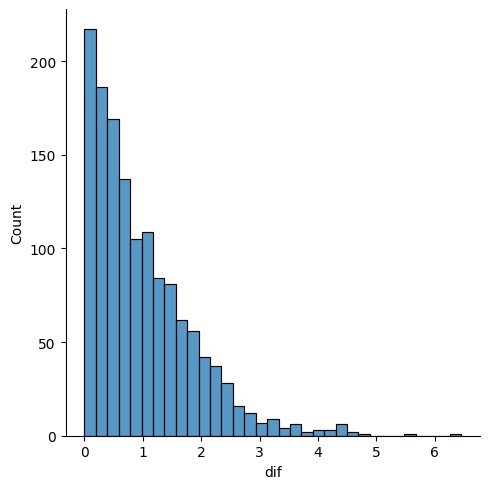

In [14]:
sns.displot(df[df.prediction == 'doublet'], x = 'dif')

In [15]:
doublets = df[(df.prediction == 'doublet') & (df.dif > 1)]
doublets

,doublet,singlet,prediction,dif
TAGGTACCATGGCCAC-1,1.069737,-1.784079,doublet,2.853817
ATTCACTGTAACAGGC-1,1.142640,-1.709824,doublet,2.852464
TTGGGTACACGACAAG-1,0.905577,-1.603958,doublet,2.509535
AGGCCACAGAGTCACG-1,0.986293,-1.494132,doublet,2.480425
CACTGAAGTCGAAGCA-1,0.792713,-1.290567,doublet,2.083281
...,...,...,...,...
ATTCTTGGTGGCTTAT-1,0.734697,-0.491081,doublet,1.225778
AGCGTCGGTACGTTCA-1,0.740603,-0.699239,doublet,1.439842
CAATACGCAATGTGGG-1,0.773488,-0.594311,doublet,1.367799
ATCAGGTGTCGTCTCT-1,0.960838,-0.680510,doublet,1.641348


In [16]:
adata = sc.read_csv('/Users/msoliai/Documents/data/sc_lung_cv19/GSE171524_RAW/GSM5226574_C51ctr_raw_counts.csv').T

In [17]:
adata.obs['doublet'] = adata.obs.index.isin(doublets.index)
adata.obs

,doublet
TAGGTACCATGGCCAC-1_1,False
ATTCACTGTAACAGGC-1_1,False
TAACTTCCAACCACGC-1_1,False
TTGGGTACACGACAAG-1_1,False
AGGCCACAGAGTCACG-1_1,False
...,...
CGCCATTGTTTGCCGG-1_1,False
CACTGGGGTCTACGTA-1_1,False
CATACTTGTAGAGGAA-1_1,False
TTTGGTTTCCACGGAC-1_1,False


In [18]:
adata = adata[~adata.obs.doublet]

In [19]:
adata

View of AnnData object with n_obs × n_vars = 6099 × 34546
    obs: 'doublet'

## Preprocessing

### Remove mt genes

In [20]:
adata.var['mt'] = adata.var.index.str.startswith('MT-')

/var/folders/9h/zlpjccbn02bfv55zvvdqbb2m0000gn/T/ipykernel_52392/310233584.py:1: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['mt'] = adata.var.index.str.startswith('MT-')


In [21]:
adata.var

,mt
AL627309.1,False
AL627309.5,False
AL627309.4,False
AL669831.2,False
LINC01409,False
...,...
VN1R2,False
AL031676.1,False
SMIM34A,False
AL050402.1,False


### Remove ribosomal genes

In [22]:
import pandas as pd

In [23]:
ribo_url = "http://software.broadinstitute.org/gsea/msigdb/download_geneset.jsp?geneSetName=KEGG_RIBOSOME&fileType=txt"

In [24]:
ribo_genes = pd.read_table(ribo_url, skiprows=2, header = None)
ribo_genes

,0
0,FAU
1,MRPL13
2,RPL10
3,RPL10A
4,RPL10L
...,...
83,RPS9
84,RPSA
85,RSL24D1
86,RSL24D1P11


In [29]:
adata.var['ribo'] = adata.var_names.isin(ribo_genes[0].values)

In [31]:
adata.obs

,doublet
TAGGTACCATGGCCAC-1_1,False
ATTCACTGTAACAGGC-1_1,False
TAACTTCCAACCACGC-1_1,False
TTGGGTACACGACAAG-1_1,False
AGGCCACAGAGTCACG-1_1,False
...,...
CGCCATTGTTTGCCGG-1_1,False
CACTGGGGTCTACGTA-1_1,False
CATACTTGTAGAGGAA-1_1,False
TTTGGTTTCCACGGAC-1_1,False


In [32]:
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt', 'ribo'], percent_top=None, log1p=False, inplace=True)

In [33]:
adata.var.sort_values('n_cells_by_counts')

,mt,ribo,n_cells,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts
AL929091.1,False,False,3,3,0.000492,99.950812,3.0
AC006441.3,False,False,3,3,0.000492,99.950812,3.0
AC022017.1,False,False,3,3,0.000492,99.950812,3.0
AC024597.1,False,False,3,3,0.000492,99.950812,3.0
PCARE,False,False,3,3,0.000492,99.950812,3.0
...,...,...,...,...,...,...,...
AKAP13,False,False,4458,4458,3.054271,26.906050,18628.0
NEAT1,False,False,4546,4546,5.314150,25.463191,32411.0
MBNL1,False,False,4554,4554,2.877029,25.332022,17547.0
ZBTB20,False,False,4699,4699,2.601082,22.954583,15864.0


In [34]:
sc.pp.filter_genes(adata, min_cells=3)

In [35]:
adata.var.sort_values('n_cells_by_counts')

,mt,ribo,n_cells,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts
AL929091.1,False,False,3,3,0.000492,99.950812,3.0
AC006441.3,False,False,3,3,0.000492,99.950812,3.0
AC022017.1,False,False,3,3,0.000492,99.950812,3.0
AC024597.1,False,False,3,3,0.000492,99.950812,3.0
PCARE,False,False,3,3,0.000492,99.950812,3.0
...,...,...,...,...,...,...,...
AKAP13,False,False,4458,4458,3.054271,26.906050,18628.0
NEAT1,False,False,4546,4546,5.314150,25.463191,32411.0
MBNL1,False,False,4554,4554,2.877029,25.332022,17547.0
ZBTB20,False,False,4699,4699,2.601082,22.954583,15864.0


In [36]:
adata.obs.sort_values('n_genes_by_counts')

,doublet,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo
TAGGGTTTCTGGCTGG-1_1,False,274,417.0,1.0,0.239808,1.0,0.239808
CGTGCTTCAAAGGGCT-1_1,False,277,432.0,41.0,9.490741,0.0,0.000000
TGACAGTTCTAAACGC-1_1,False,277,413.0,0.0,0.000000,0.0,0.000000
CTCTGGTCACGACGAA-1_1,False,284,406.0,0.0,0.000000,0.0,0.000000
GTAAGTCGTATCGCGC-1_1,False,288,429.0,0.0,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...
TAACTTCCAACCACGC-1_1,False,5145,15631.0,221.0,1.413857,211.0,1.349882
CACTGAAGTCGAAGCA-1_1,False,5471,12709.0,355.0,2.793296,82.0,0.645212
AGGCCACAGAGTCACG-1_1,False,5529,13202.0,417.0,3.158612,82.0,0.621118
ATTCACTGTAACAGGC-1_1,False,6661,18994.0,404.0,2.126987,115.0,0.605454


In [37]:
sc.pp.filter_genes(adata, min_cells=3)

In [38]:
adata.var.sort_values('n_cells_by_counts')

,mt,ribo,n_cells,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts
AL929091.1,False,False,3,3,0.000492,99.950812,3.0
AC006441.3,False,False,3,3,0.000492,99.950812,3.0
AC022017.1,False,False,3,3,0.000492,99.950812,3.0
AC024597.1,False,False,3,3,0.000492,99.950812,3.0
PCARE,False,False,3,3,0.000492,99.950812,3.0
...,...,...,...,...,...,...,...
AKAP13,False,False,4458,4458,3.054271,26.906050,18628.0
NEAT1,False,False,4546,4546,5.314150,25.463191,32411.0
MBNL1,False,False,4554,4554,2.877029,25.332022,17547.0
ZBTB20,False,False,4699,4699,2.601082,22.954583,15864.0


In [33]:
adata.obs.sort_values('n_genes_by_counts')

,doublet,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo
TAGGGTTTCTGGCTGG-1_1,False,276,419.0,1.0,0.238663,1.0,0.238663
CGTGCTTCAAAGGGCT-1_1,False,277,432.0,41.0,9.490741,0.0,0.000000
TGACAGTTCTAAACGC-1_1,False,278,414.0,0.0,0.000000,0.0,0.000000
CTCTGGTCACGACGAA-1_1,False,285,407.0,0.0,0.000000,0.0,0.000000
GTAAGTCGTATCGCGC-1_1,False,289,430.0,0.0,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...
TAACTTCCAACCACGC-1_1,False,5158,15645.0,221.0,1.412592,211.0,1.348674
CACTGAAGTCGAAGCA-1_1,False,5487,12725.0,355.0,2.789784,82.0,0.644401
AGGCCACAGAGTCACG-1_1,False,5544,13217.0,417.0,3.155028,82.0,0.620413
ATTCACTGTAACAGGC-1_1,False,6686,19020.0,404.0,2.124080,115.0,0.604627


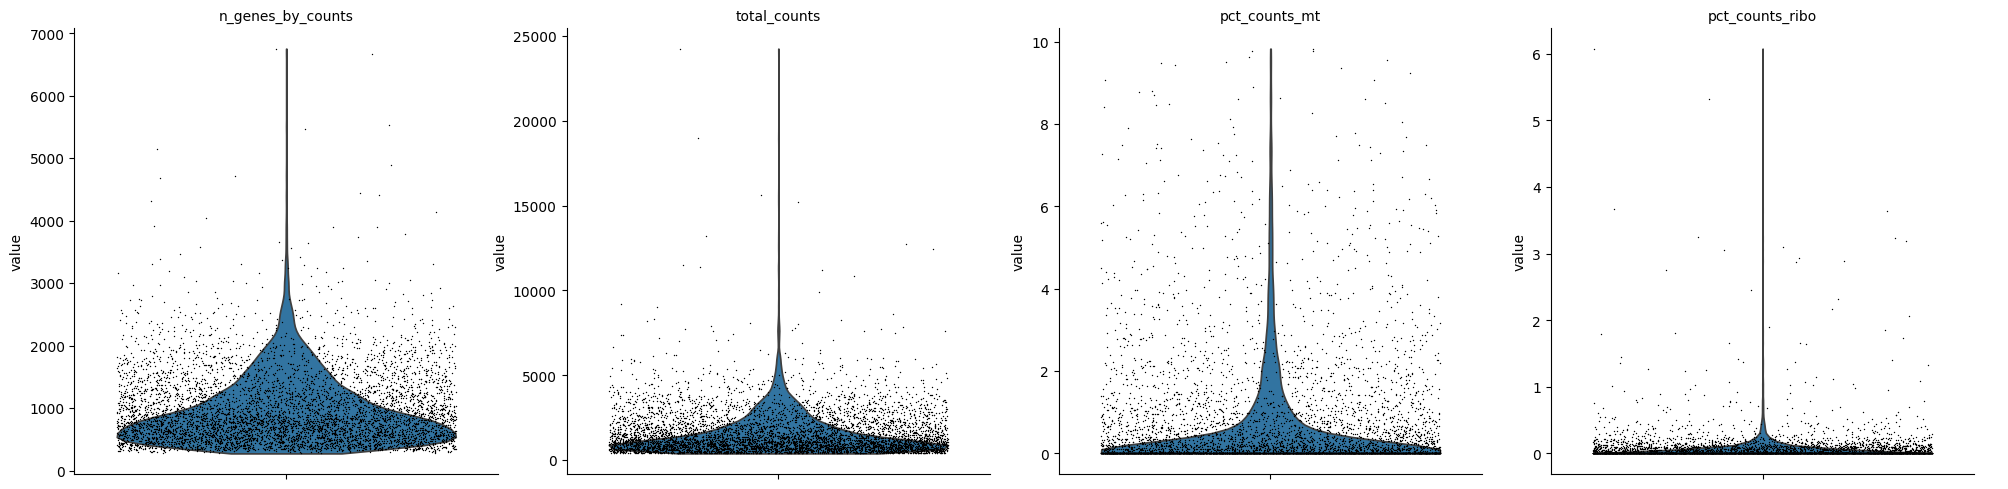

In [39]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo'], 
             jitter=0.4, multi_panel=True)

In [40]:
import numpy as np

In [41]:
upper_lim = np.quantile(adata.obs.n_genes_by_counts.values, .98)
#upper_lim = 3000

In [42]:
upper_lim

2474.12

In [43]:
adata = adata[adata.obs.n_genes_by_counts < upper_lim]

In [44]:
adata.obs

,doublet,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo
CGTTCTGGTACTAGCT-1_1,False,2430,6043.0,6.0,0.099288,1.0,0.016548
CTGGCAGGTTCGGTAT-1_1,False,2440,5895.0,307.0,5.207803,5.0,0.084818
ACACCAACACAACGCC-1_1,False,2450,5496.0,0.0,0.000000,3.0,0.054585
CCTCAACCATACAGGG-1_1,False,2275,5433.0,38.0,0.699429,0.0,0.000000
ACAAAGATCCACAGGC-1_1,False,2309,5503.0,1.0,0.018172,1.0,0.018172
...,...,...,...,...,...,...,...
CGCCATTGTTTGCCGG-1_1,False,355,410.0,3.0,0.731707,0.0,0.000000
CACTGGGGTCTACGTA-1_1,False,346,403.0,0.0,0.000000,0.0,0.000000
CATACTTGTAGAGGAA-1_1,False,360,410.0,2.0,0.487805,0.0,0.000000
TTTGGTTTCCACGGAC-1_1,False,299,405.0,0.0,0.000000,2.0,0.493827


In [45]:
adata = adata[adata.obs.pct_counts_mt < 20]

In [46]:
adata = adata[adata.obs.pct_counts_ribo < 2]

In [47]:
adata

View of AnnData object with n_obs × n_vars = 5960 × 24660
    obs: 'doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'mt', 'ribo', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

## Normalization

In [48]:
adata.X.sum(axis = 1)

array([6043., 5895., 5496., ...,  410.,  405.,  410.], dtype=float32)

In [49]:
sc.pp.normalize_total(adata, target_sum=1e4) #normalize every cell to 10,000 UMI

/opt/homebrew/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [50]:
adata.X.sum(axis = 1)

array([10000., 10000., 10000., ..., 10000., 10000., 10000.], dtype=float32)

In [51]:
sc.pp.log1p(adata) #change to log counts

In [52]:
adata.X.sum(axis = 1)

array([3155.047  , 3218.0122 , 3416.0486 , ..., 1191.2708 , 1022.75116,
       1162.8785 ], dtype=float32)

In [53]:
adata.raw = adata

## Clustering

In [54]:
sc.pp.highly_variable_genes(adata, n_top_genes = 2000)

/opt/homebrew/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby("mean_bin")["dispersions"]


In [55]:
adata.var

,mt,ribo,n_cells,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,highly_variable,means,dispersions,dispersions_norm
AL627309.1,False,False,8,8,0.001312,99.868831,8.0,True,0.010824,2.722189,1.226735
AL627309.5,False,False,33,33,0.005411,99.458928,33.0,False,0.028855,2.254608,-0.150401
AL627309.4,False,False,4,4,0.000656,99.934415,4.0,False,0.002331,1.702854,-1.775449
LINC01409,False,False,274,274,0.048697,95.507460,297.0,False,0.270478,2.286819,-0.055532
FAM87B,False,False,6,6,0.000984,99.901623,6.0,False,0.006682,1.947490,-1.054937
...,...,...,...,...,...,...,...,...,...,...,...
AL354822.1,False,False,133,133,0.022627,97.819315,138.0,False,0.153974,2.375807,0.206557
AL592183.1,False,False,1003,1003,0.198721,83.554681,1212.0,False,0.874963,2.469800,-0.405991
AC240274.1,False,False,162,162,0.027382,97.343827,167.0,False,0.150268,2.265893,-0.117165
AC007325.4,False,False,4,4,0.000656,99.934415,4.0,False,0.002801,1.579830,-2.137784


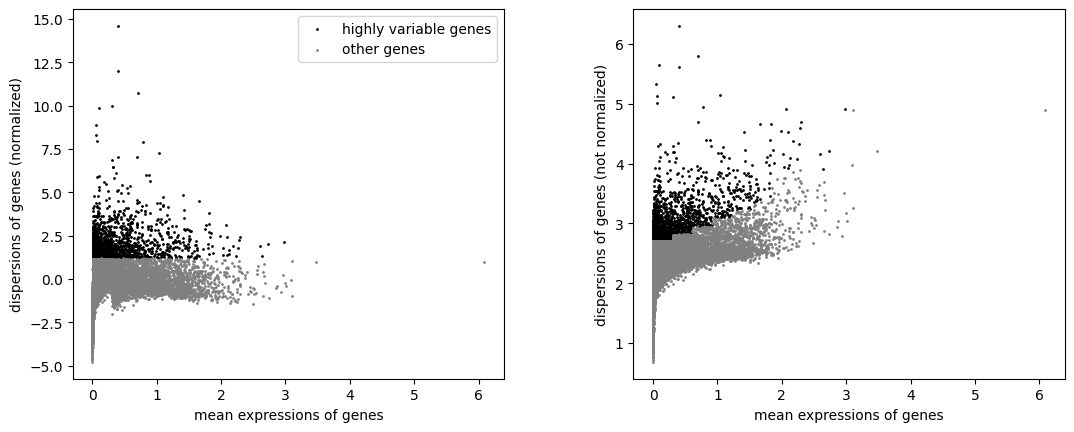

In [56]:
sc.pl.highly_variable_genes(adata)

In [57]:
adata = adata[:, adata.var.highly_variable]

In [58]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt', 'pct_counts_ribo'])

In [59]:
sc.pp.scale(adata, max_value=10)

In [60]:
sc.tl.pca(adata, svd_solver='arpack')

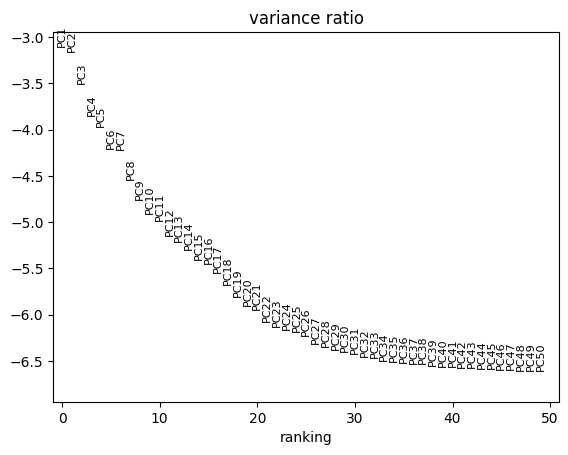

In [61]:
sc.pl.pca_variance_ratio(adata, log=True, n_pcs = 50)

In [62]:
sc.pp.neighbors(adata, n_pcs = 30)

In [63]:
sc.tl.umap(adata)

/opt/homebrew/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


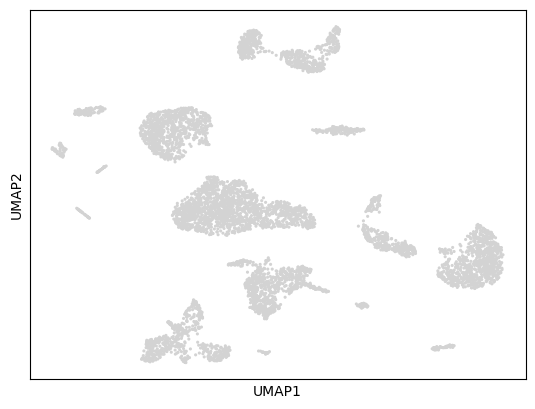

In [64]:
sc.pl.umap(adata)

In [65]:
sc.tl.leiden(adata, resolution = 0.5)

In [66]:
adata.obs

,doublet,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo,leiden
CGTTCTGGTACTAGCT-1_1,False,2430,6043.0,6.0,0.099288,1.0,0.016548,2
CTGGCAGGTTCGGTAT-1_1,False,2440,5895.0,307.0,5.207803,5.0,0.084818,2
ACACCAACACAACGCC-1_1,False,2450,5496.0,0.0,0.000000,3.0,0.054585,1
CCTCAACCATACAGGG-1_1,False,2275,5433.0,38.0,0.699429,0.0,0.000000,10
ACAAAGATCCACAGGC-1_1,False,2309,5503.0,1.0,0.018172,1.0,0.018172,2
...,...,...,...,...,...,...,...,...
CGCCATTGTTTGCCGG-1_1,False,355,410.0,3.0,0.731707,0.0,0.000000,7
CACTGGGGTCTACGTA-1_1,False,346,403.0,0.0,0.000000,0.0,0.000000,1
CATACTTGTAGAGGAA-1_1,False,360,410.0,2.0,0.487805,0.0,0.000000,0
TTTGGTTTCCACGGAC-1_1,False,299,405.0,0.0,0.000000,2.0,0.493827,11


/opt/homebrew/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/homebrew/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


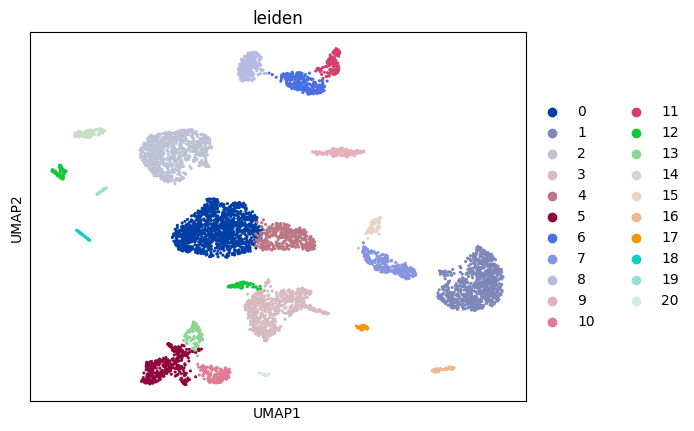

In [67]:
sc.pl.umap(adata, color=['leiden'])

## Integration

In [68]:
def pp(csv_path):
    adata = sc.read_csv(csv_path).T
    sc.pp.filter_genes(adata, min_cells = 10)
    sc.pp.highly_variable_genes(adata, n_top_genes = 2000, subset = True, flavor = 'seurat_v3')
    scvi.model.SCVI.setup_anndata(adata)
    vae = scvi.model.SCVI(adata)
    vae.train()
    solo = scvi.external.SOLO.from_scvi_model(vae)
    solo.train()
    df = solo.predict()
    df['prediction'] = solo.predict(soft = False)
    df.index = df.index.map(lambda x: x[:-2])
    df['dif'] = df.doublet - df.singlet
    doublets = df[(df.prediction == 'doublet') & (df.dif > 1)]
    
    adata = sc.read_csv(csv_path).T
    adata.obs['Sample'] = csv_path.split('_')[2] #'raw_counts/GSM5226574_C51ctr_raw_counts.csv'
    
    adata.obs['doublet'] = adata.obs.index.isin(doublets.index)
    adata = adata[~adata.obs.doublet]
    
    
    sc.pp.filter_cells(adata, min_genes=200) #get rid of cells with fewer than 200 genes
    #sc.pp.filter_genes(adata, min_cells=3) #get rid of genes that are found in fewer than 3 cells
    adata.var['mt'] = adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
    adata.var['ribo'] = adata.var_names.isin(ribo_genes[0].values)
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt', 'ribo'], percent_top=None, log1p=False, inplace=True)
    upper_lim = np.quantile(adata.obs.n_genes_by_counts.values, .98)
    adata = adata[adata.obs.n_genes_by_counts < upper_lim]
    adata = adata[adata.obs.pct_counts_mt < 20]
    adata = adata[adata.obs.pct_counts_ribo < 2]

    return adata

In [69]:
import os

In [70]:
out = []
for file in os.listdir('/Users/msoliai/Documents/data/sc_lung_cv19/GSE171524_RAW/'):
    out.append(pp('/Users/msoliai/Documents/data/sc_lung_cv19/GSE171524_RAW/' + file))

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Epoch 400/400: 100%|█████| 400/400 [03:40<00:00,  1.80it/s, v_num=1, train_loss_step=273, train_loss_epoch=305]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|█████| 400/400 [03:40<00:00,  1.81it/s, v_num=1, train_loss_step=273, train_loss_epoch=305]
INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader`

Epoch 296/400:  74%|█▍| 296/400 [00:28<00:10, 10.25it/s, v_num=1, train_loss_step=0.207, train_loss_epoch=0.22]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.222. Signaling Trainer to stop.


/opt/homebrew/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:139: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Epoch 400/400: 100%|█████| 400/400 [03:16<00:00,  1.87it/s, v_num=1, train_loss_step=329, train_loss_epoch=329]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|█████| 400/400 [03:16<00:00,  2.04it/s, v_num=1, train_loss_step=329, train_loss_epoch=329]
INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader`

Epoch 229/400:  57%|▌| 229/400 [00:18<00:13, 12.26it/s, v_num=1, train_loss_step=0.257, train_loss_epoch=0.282]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.266. Signaling Trainer to stop.


/opt/homebrew/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:139: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Epoch 400/400: 100%|█████| 400/400 [20:23<00:00,  2.26it/s, v_num=1, train_loss_step=279, train_loss_epoch=289]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|█████| 400/400 [20:23<00:00,  3.06s/it, v_num=1, train_loss_step=279, train_loss_epoch=289]
INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader`

Epoch 240/400:  60%|█▏| 240/400 [15:44<10:29,  3.93s/it, v_num=1, train_loss_step=0.82, train_loss_epoch=0.256]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.228. Signaling Trainer to stop.


/opt/homebrew/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:139: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Epoch 400/400: 100%|█████| 400/400 [32:53<00:00,  1.48it/s, v_num=1, train_loss_step=448, train_loss_epoch=332]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|█████| 400/400 [32:53<00:00,  4.93s/it, v_num=1, train_loss_step=448, train_loss_epoch=332]
INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader`

Epoch 136/400:  34%|▋ | 136/400 [00:16<00:31,  8.47it/s, v_num=1, train_loss_step=0.23, train_loss_epoch=0.317]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.312. Signaling Trainer to stop.


/opt/homebrew/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:139: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Epoch 400/400: 100%|█████| 400/400 [03:12<00:00,  2.09it/s, v_num=1, train_loss_step=404, train_loss_epoch=371]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|█████| 400/400 [03:12<00:00,  2.08it/s, v_num=1, train_loss_step=404, train_loss_epoch=371]
INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader`

Epoch 317/400:  79%|█▌| 317/400 [00:27<00:07, 11.71it/s, v_num=1, train_loss_step=0.284, train_loss_epoch=0.29]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.265. Signaling Trainer to stop.


/opt/homebrew/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:139: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Epoch 400/400: 100%|█████| 400/400 [03:56<00:00,  1.33it/s, v_num=1, train_loss_step=432, train_loss_epoch=472]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|█████| 400/400 [03:56<00:00,  1.69it/s, v_num=1, train_loss_step=432, train_loss_epoch=472]
INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader`

Epoch 230/400:  57%|▌| 230/400 [00:38<00:28,  6.01it/s, v_num=1, train_loss_step=0.374, train_loss_epoch=0.338]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.341. Signaling Trainer to stop.


/opt/homebrew/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:139: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Epoch 400/400: 100%|█████| 400/400 [03:03<00:00,  2.24it/s, v_num=1, train_loss_step=337, train_loss_epoch=336]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|█████| 400/400 [03:03<00:00,  2.17it/s, v_num=1, train_loss_step=337, train_loss_epoch=336]
INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader`

Epoch 222/400:  56%|▌| 222/400 [00:16<00:13, 13.08it/s, v_num=1, train_loss_step=0.0673, train_loss_epoch=0.249
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.251. Signaling Trainer to stop.


/opt/homebrew/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:139: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Epoch 400/400: 100%|█████| 400/400 [01:39<00:00,  4.04it/s, v_num=1, train_loss_step=409, train_loss_epoch=414]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|█████| 400/400 [01:39<00:00,  4.02it/s, v_num=1, train_loss_step=409, train_loss_epoch=414]
INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader`

Epoch 255/400:  64%|▋| 255/400 [00:11<00:06, 21.77it/s, v_num=1, train_loss_step=0.294, train_loss_epoch=0.319]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.330. Signaling Trainer to stop.


/opt/homebrew/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:139: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Epoch 400/400: 100%|█████| 400/400 [02:15<00:00,  2.88it/s, v_num=1, train_loss_step=564, train_loss_epoch=319]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|█████| 400/400 [02:15<00:00,  2.95it/s, v_num=1, train_loss_step=564, train_loss_epoch=319]
INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader`

Epoch 153/400:  38%|▍| 153/400 [00:09<00:14, 16.90it/s, v_num=1, train_loss_step=0.322, train_loss_epoch=0.311]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.303. Signaling Trainer to stop.


/opt/homebrew/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:139: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Epoch 400/400: 100%|█████| 400/400 [04:58<00:00,  1.14it/s, v_num=1, train_loss_step=319, train_loss_epoch=361]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|█████| 400/400 [04:58<00:00,  1.34it/s, v_num=1, train_loss_step=319, train_loss_epoch=361]
INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader`

Epoch 257/400:  64%|▋| 257/400 [17:10<09:33,  4.01s/it, v_num=1, train_loss_step=0.219, train_loss_epoch=0.298]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.283. Signaling Trainer to stop.


/opt/homebrew/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:139: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Epoch 400/400: 100%|█████| 400/400 [30:52<00:00,  1.52it/s, v_num=1, train_loss_step=336, train_loss_epoch=323]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|█████| 400/400 [30:52<00:00,  4.63s/it, v_num=1, train_loss_step=336, train_loss_epoch=323]
INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader`

Epoch 317/400:  79%|▊| 317/400 [15:32<04:04,  2.94s/it, v_num=1, train_loss_step=0.294, train_loss_epoch=0.288]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.258. Signaling Trainer to stop.


/opt/homebrew/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:139: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Epoch 400/400: 100%|█████| 400/400 [16:54<00:00,  3.80it/s, v_num=1, train_loss_step=398, train_loss_epoch=382]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|█████| 400/400 [16:54<00:00,  2.54s/it, v_num=1, train_loss_step=398, train_loss_epoch=382]
INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader`

Epoch 400/400: 100%|██| 400/400 [00:51<00:00, 29.64it/s, v_num=1, train_loss_step=0.19, train_loss_epoch=0.284]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██| 400/400 [00:51<00:00,  7.74it/s, v_num=1, train_loss_step=0.19, train_loss_epoch=0.284]


/opt/homebrew/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:139: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Epoch 400/400: 100%|████| 400/400 [20:17<00:00, 307.07s/it, v_num=1, train_loss_step=317, train_loss_epoch=360]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|█████| 400/400 [20:17<00:00,  3.04s/it, v_num=1, train_loss_step=317, train_loss_epoch=360]
INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader`

Epoch 216/400:  54%|▌| 216/400 [00:14<00:11, 15.39it/s, v_num=1, train_loss_step=0.359, train_loss_epoch=0.348]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.346. Signaling Trainer to stop.


/opt/homebrew/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:139: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Epoch 400/400: 100%|█████| 400/400 [05:03<00:00,  3.17it/s, v_num=1, train_loss_step=325, train_loss_epoch=344]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|█████| 400/400 [05:03<00:00,  1.32it/s, v_num=1, train_loss_step=325, train_loss_epoch=344]
INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader`

Epoch 129/400:  32%|▎| 129/400 [00:07<00:15, 18.03it/s, v_num=1, train_loss_step=0.439, train_loss_epoch=0.337]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.346. Signaling Trainer to stop.


/opt/homebrew/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:139: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Epoch 400/400: 100%|█████| 400/400 [24:20<00:00,  2.40it/s, v_num=1, train_loss_step=397, train_loss_epoch=353]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|█████| 400/400 [24:20<00:00,  3.65s/it, v_num=1, train_loss_step=397, train_loss_epoch=353]
INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader`

Epoch 164/400:  41%|▊ | 164/400 [00:11<00:16, 14.22it/s, v_num=1, train_loss_step=0.34, train_loss_epoch=0.293]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.276. Signaling Trainer to stop.


/opt/homebrew/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:139: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Epoch 400/400: 100%|█████| 400/400 [21:22<00:00,  2.08it/s, v_num=1, train_loss_step=417, train_loss_epoch=397]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|█████| 400/400 [21:22<00:00,  3.21s/it, v_num=1, train_loss_step=417, train_loss_epoch=397]
INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader`

Epoch 299/400:  75%|▋| 299/400 [00:23<00:07, 12.64it/s, v_num=1, train_loss_step=0.327, train_loss_epoch=0.292]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.299. Signaling Trainer to stop.


/opt/homebrew/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:139: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Epoch 400/400: 100%|█████| 400/400 [11:02<00:00,  2.10it/s, v_num=1, train_loss_step=341, train_loss_epoch=339]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|█████| 400/400 [11:02<00:00,  1.66s/it, v_num=1, train_loss_step=341, train_loss_epoch=339]
INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader`

Epoch 242/400:  60%|▌| 242/400 [00:21<00:14, 11.04it/s, v_num=1, train_loss_step=0.231, train_loss_epoch=0.293]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.297. Signaling Trainer to stop.


/opt/homebrew/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:139: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Epoch 400/400: 100%|█████| 400/400 [03:34<00:00,  1.84it/s, v_num=1, train_loss_step=336, train_loss_epoch=318]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|█████| 400/400 [03:34<00:00,  1.87it/s, v_num=1, train_loss_step=336, train_loss_epoch=318]
INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader`

Epoch 295/400:  74%|▋| 295/400 [00:38<00:13,  7.62it/s, v_num=1, train_loss_step=0.262, train_loss_epoch=0.306]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.288. Signaling Trainer to stop.


/opt/homebrew/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:139: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Epoch 400/400: 100%|█████| 400/400 [01:27<00:00,  4.52it/s, v_num=1, train_loss_step=312, train_loss_epoch=312]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|█████| 400/400 [01:27<00:00,  4.58it/s, v_num=1, train_loss_step=312, train_loss_epoch=312]
INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader`

Epoch 288/400:  72%|▋| 288/400 [00:16<00:06, 17.07it/s, v_num=1, train_loss_step=0.296, train_loss_epoch=0.267]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.298. Signaling Trainer to stop.


/opt/homebrew/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:139: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Epoch 400/400: 100%|█████| 400/400 [02:42<00:00,  2.59it/s, v_num=1, train_loss_step=303, train_loss_epoch=258]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|█████| 400/400 [02:42<00:00,  2.46it/s, v_num=1, train_loss_step=303, train_loss_epoch=258]
INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader`

Epoch 230/400:  57%|▌| 230/400 [00:16<00:12, 14.09it/s, v_num=1, train_loss_step=0.297, train_loss_epoch=0.278]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.273. Signaling Trainer to stop.


/opt/homebrew/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:139: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Epoch 400/400: 100%|█████| 400/400 [03:25<00:00,  1.85it/s, v_num=1, train_loss_step=304, train_loss_epoch=307]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|█████| 400/400 [03:25<00:00,  1.95it/s, v_num=1, train_loss_step=304, train_loss_epoch=307]
INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader`

Epoch 223/400:  56%|▌| 223/400 [00:18<00:14, 12.31it/s, v_num=1, train_loss_step=0.259, train_loss_epoch=0.235]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.225. Signaling Trainer to stop.


/opt/homebrew/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:139: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Epoch 400/400: 100%|█████| 400/400 [02:16<00:00,  3.10it/s, v_num=1, train_loss_step=323, train_loss_epoch=331]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|█████| 400/400 [02:16<00:00,  2.92it/s, v_num=1, train_loss_step=323, train_loss_epoch=331]
INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader`

Epoch 298/400:  74%|▋| 298/400 [00:18<00:06, 15.98it/s, v_num=1, train_loss_step=0.391, train_loss_epoch=0.276]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.283. Signaling Trainer to stop.


/opt/homebrew/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:139: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Epoch 400/400: 100%|█████| 400/400 [04:26<00:00,  1.48it/s, v_num=1, train_loss_step=339, train_loss_epoch=340]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|█████| 400/400 [04:26<00:00,  1.50it/s, v_num=1, train_loss_step=339, train_loss_epoch=340]
INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader`

Epoch 333/400:  83%|▊| 333/400 [00:58<00:11,  5.71it/s, v_num=1, train_loss_step=0.969, train_loss_epoch=0.264]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.247. Signaling Trainer to stop.


/opt/homebrew/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:139: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Epoch 400/400: 100%|█████| 400/400 [03:53<00:00,  1.83it/s, v_num=1, train_loss_step=316, train_loss_epoch=339]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|█████| 400/400 [03:53<00:00,  1.71it/s, v_num=1, train_loss_step=316, train_loss_epoch=339]
INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader`

Epoch 168/400:  42%|▍| 168/400 [00:16<00:23, 10.06it/s, v_num=1, train_loss_step=0.413, train_loss_epoch=0.359]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.338. Signaling Trainer to stop.


/opt/homebrew/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:139: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Epoch 400/400: 100%|█████| 400/400 [03:24<00:00,  2.19it/s, v_num=1, train_loss_step=332, train_loss_epoch=325]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|█████| 400/400 [03:24<00:00,  1.96it/s, v_num=1, train_loss_step=332, train_loss_epoch=325]
INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader`

Epoch 251/400:  63%|▋| 251/400 [00:20<00:11, 12.49it/s, v_num=1, train_loss_step=0.245, train_loss_epoch=0.256]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.255. Signaling Trainer to stop.


/opt/homebrew/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:139: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Epoch 400/400: 100%|█████| 400/400 [02:41<00:00,  2.56it/s, v_num=1, train_loss_step=298, train_loss_epoch=303]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|█████| 400/400 [02:41<00:00,  2.48it/s, v_num=1, train_loss_step=298, train_loss_epoch=303]
INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader`

Epoch 195/400:  49%|▍| 195/400 [00:20<00:21,  9.56it/s, v_num=1, train_loss_step=0.161, train_loss_epoch=0.202]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.208. Signaling Trainer to stop.


/opt/homebrew/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:139: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Epoch 400/400: 100%|█████| 400/400 [05:14<00:00,  1.13it/s, v_num=1, train_loss_step=333, train_loss_epoch=341]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|█████| 400/400 [05:14<00:00,  1.27it/s, v_num=1, train_loss_step=333, train_loss_epoch=341]
INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader`

Epoch 245/400:  61%|▌| 245/400 [00:34<00:21,  7.07it/s, v_num=1, train_loss_step=0.548, train_loss_epoch=0.311]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.294. Signaling Trainer to stop.


/opt/homebrew/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:139: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number


In [71]:
adata = sc.concat(out)

In [72]:
adata

AnnData object with n_obs × n_vars = 108822 × 34546
    obs: 'Sample', 'doublet', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'

In [73]:
sc.pp.filter_genes(adata, min_cells = 10)

In [74]:
adata.X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [75]:
from scipy.sparse import csr_matrix

In [76]:
adata.X = csr_matrix(adata.X)

In [77]:
adata.X

<108822x29581 sparse matrix of type '<class 'numpy.float32'>'
	with 95760461 stored elements in Compressed Sparse Row format>

In [78]:
adata.write_h5ad('/Users/msoliai/Documents/data/sc_lung_cv19/combined.h5ad')

In [79]:
########################################################

In [81]:
import scanpy as sc
import scvi
import seaborn as sns
import numpy as np
import pandas as pd
import random
random.seed(0)

In [83]:
adata = sc.read_h5ad('/Users/msoliai/Documents/data/sc_lung_cv19/combined.h5ad')
adata

AnnData object with n_obs × n_vars = 108822 × 29581
    obs: 'Sample', 'doublet', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'n_cells'

In [85]:
adata.obs.groupby('Sample', observed=True).count()

,doublet,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo
Sample,,,,,,,,
cv19/GSE171524,108822,108822,108822,108822,108822,108822,108822,108822


In [91]:
sc.pp.filter_genes(adata, min_cells = 100)

In [92]:
adata

AnnData object with n_obs × n_vars = 108822 × 21306
    obs: 'Sample', 'doublet', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'n_cells'

In [93]:
adata.layers['counts'] = adata.X.copy()

In [94]:
sc.pp.normalize_total(adata, target_sum = 1e4)
sc.pp.log1p(adata)
adata.raw = adata

In [95]:
adata.obs.head()

,Sample,doublet,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo
TCATATCTCTTCTAAC-1_5,cv19/GSE171524,False,1535,1535,4616.0,0.0,0.0,0.0,0.000000
TGCAGTAAGGCCACCT-1_5,cv19/GSE171524,False,1476,1476,4428.0,0.0,0.0,3.0,0.067751
CGGGACTAGTCACTCA-1_5,cv19/GSE171524,False,1607,1607,3857.0,0.0,0.0,1.0,0.025927
ACCTGTCCAGGGTCTC-1_5,cv19/GSE171524,False,1592,1592,3913.0,0.0,0.0,0.0,0.000000
CACAGGCTCGCATTGA-1_5,cv19/GSE171524,False,1603,1603,3685.0,0.0,0.0,3.0,0.081411


In [96]:
adata

AnnData object with n_obs × n_vars = 108822 × 21306
    obs: 'Sample', 'doublet', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'n_cells'
    uns: 'log1p'
    layers: 'counts'

In [97]:
scvi.model.SCVI.setup_anndata(adata, layer = "counts",
                             categorical_covariate_keys=["Sample"],
                             continuous_covariate_keys=['pct_counts_mt', 'total_counts', 'pct_counts_ribo'])

In [98]:
model = scvi.model.SCVI(adata)

In [103]:
model.train() #may take a while without GPU

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/msoliai/Documents/py_env/scrnaseq_scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Epoch 74/74: 100%|█| 74/74 [6:02:03<00:00, 481.34s/it, v_num=1, train_loss_step=3.19e+3, train_loss_epoch=2.96e

`Trainer.fit` stopped: `max_epochs=74` reached.


Epoch 74/74: 100%|█| 74/74 [6:02:03<00:00, 293.56s/it, v_num=1, train_loss_step=3.19e+3, train_loss_epoch=2.96e


In [104]:
adata.obsm['X_scVI'] = model.get_latent_representation()

In [105]:
adata.layers['scvi_normalized'] = model.get_normalized_expression(library_size = 1e4)

In [106]:
sc.pp.neighbors(adata, use_rep = 'X_scVI')

In [107]:
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution = 0.5)

/opt/homebrew/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/homebrew/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/homebrew/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/homebrew/lib/python3.10/site-packages/sca

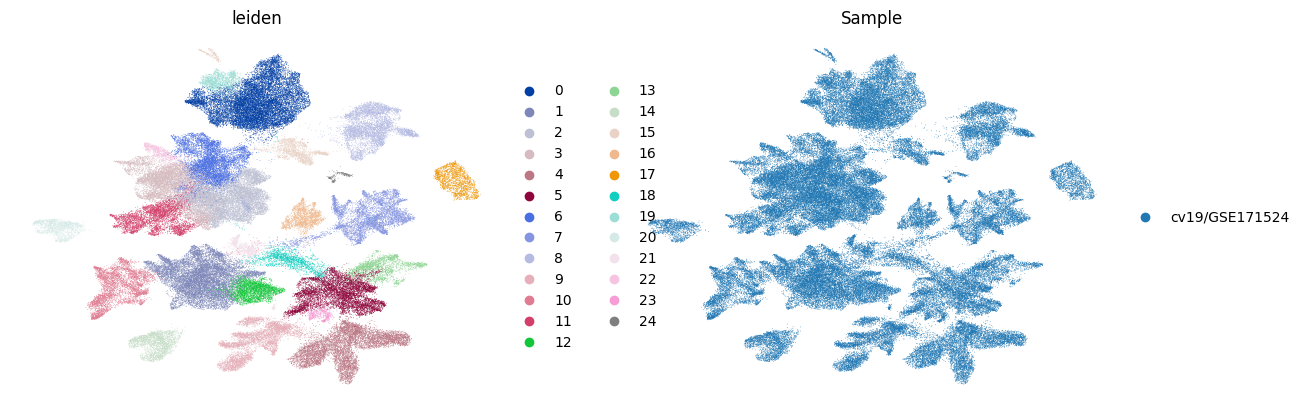

In [108]:
sc.pl.umap(adata, color = ['leiden', 'Sample'], frameon = False)

In [110]:
adata.write_h5ad('integrated.h5ad')

## Find markers/ label cell types

In [111]:
sc.tl.leiden(adata, resolution = 1)

In [112]:
sc.tl.rank_genes_groups(adata, 'leiden')

/opt/homebrew/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/opt/homebrew/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:398: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/opt/homebrew/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:401: PerformanceWarning: DataFrame is highly fragmented.  This is usually t

In [109]:
#sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)

In [113]:
markers = sc.get.rank_genes_groups_df(adata, None)
markers = markers[(markers.pvals_adj < 0.05) & (markers.logfoldchanges > .5)]
markers

/opt/homebrew/lib/python3.10/site-packages/scanpy/get/get.py:69: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  d = d.stack(level=1).reset_index()


,group,names,scores,logfoldchanges,pvals,pvals_adj
0,0,COL6A3,152.874466,5.947805,0.000000,0.000000
1,0,LAMA2,146.288666,5.548179,0.000000,0.000000
2,0,PRKG1,145.128540,4.045359,0.000000,0.000000
3,0,COL1A2,132.277420,5.643365,0.000000,0.000000
4,0,CACNA1C,130.806320,5.085547,0.000000,0.000000
...,...,...,...,...,...,...
895517,42,AL512603.2,2.315688,3.925910,0.024132,0.049215
895518,42,AC073529.1,2.315498,2.892816,0.024143,0.049228
895519,42,IQCA1,2.313180,2.963084,0.024279,0.049486
895520,42,AL136441.1,2.312215,3.534440,0.024336,0.049598


In [114]:
markers_scvi = model.differential_expression(groupby = 'leiden')
markers_scvi

DE...: 100%|███████████████████████████████████████████████████████████████████| 43/43 [41:15<00:00, 57.57s/it]


,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,...,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05,comparison,group1,group2
AC009518.1,0.9916,0.0084,4.771087,0.000021,9.240841e-07,0.0,0.25,5.632120,5.661123,2.717624,...,0.028457,0.000464,0.018351,0.000454,0.114358,0.004151,True,0 vs Rest,0,Rest
GREM1,0.9914,0.0086,4.747355,0.000144,1.834108e-05,0.0,0.25,9.067543,9.644624,4.203830,...,0.132313,0.018618,0.063697,0.008193,0.832714,0.144613,True,0 vs Rest,0,Rest
COL1A1,0.9906,0.0094,4.657600,0.002632,1.909854e-04,0.0,0.25,6.404181,6.370456,3.741048,...,6.364408,0.318052,0.608644,0.048341,29.686626,1.916391,True,0 vs Rest,0,Rest
POSTN,0.9904,0.0096,4.636345,0.000534,8.082281e-05,0.0,0.25,7.433723,7.802725,4.545435,...,0.724067,0.100611,0.164761,0.025656,3.724264,0.767372,True,0 vs Rest,0,Rest
AC022424.2,0.9904,0.0096,4.636345,0.000025,1.423881e-06,0.0,0.25,5.547145,5.760691,2.462070,...,0.020080,0.000721,0.013963,0.000464,0.082229,0.003637,True,0 vs Rest,0,Rest
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ATG4B,0.4992,0.5008,-0.003200,0.000063,6.165275e-05,0.0,0.25,0.077183,0.074078,0.400564,...,0.084746,0.087638,0.084746,0.079990,1.237671,0.661451,False,42 vs Rest,42,Rest
DYNC1LI2,0.4908,0.5092,-0.036804,0.000079,8.478010e-05,0.0,0.25,-0.069480,-0.070879,0.352871,...,0.033898,0.124497,0.033898,0.109467,0.402236,0.891315,False,42 vs Rest,42,Rest
ILKAP,0.4802,0.5198,-0.079241,0.000061,6.525316e-05,0.0,0.25,-0.064043,-0.042704,0.352694,...,0.016949,0.096988,0.016949,0.088081,0.342407,0.763048,False,42 vs Rest,42,Rest
SMU1,0.4644,0.5356,-0.142641,0.000031,3.280497e-05,0.0,0.25,-0.065282,-0.071157,0.360322,...,0.000000,0.045115,0.000000,0.042643,0.000000,0.346915,False,42 vs Rest,42,Rest


In [115]:
markers_scvi = markers_scvi[(markers_scvi['is_de_fdr_0.05']) & (markers_scvi.lfc_mean > .5)]
markers_scvi

,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,...,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05,comparison,group1,group2
AC009518.1,0.9916,0.0084,4.771087,0.000021,9.240841e-07,0.0,0.25,5.632120,5.661123,2.717624,...,0.028457,0.000464,0.018351,0.000454,0.114358,0.004151,True,0 vs Rest,0,Rest
GREM1,0.9914,0.0086,4.747355,0.000144,1.834108e-05,0.0,0.25,9.067543,9.644624,4.203830,...,0.132313,0.018618,0.063697,0.008193,0.832714,0.144613,True,0 vs Rest,0,Rest
COL1A1,0.9906,0.0094,4.657600,0.002632,1.909854e-04,0.0,0.25,6.404181,6.370456,3.741048,...,6.364408,0.318052,0.608644,0.048341,29.686626,1.916391,True,0 vs Rest,0,Rest
POSTN,0.9904,0.0096,4.636345,0.000534,8.082281e-05,0.0,0.25,7.433723,7.802725,4.545435,...,0.724067,0.100611,0.164761,0.025656,3.724264,0.767372,True,0 vs Rest,0,Rest
AC022424.2,0.9904,0.0096,4.636345,0.000025,1.423881e-06,0.0,0.25,5.547145,5.760691,2.462070,...,0.020080,0.000721,0.013963,0.000464,0.082229,0.003637,True,0 vs Rest,0,Rest
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AC023157.3,0.8616,0.1384,1.828643,0.000003,2.016746e-06,0.0,0.25,1.018513,0.929644,1.275494,...,0.000000,0.002666,0.000000,0.002593,0.000000,0.019754,True,42 vs Rest,42,Rest
TNKS1BP1,0.8616,0.1384,1.828643,0.000062,4.184298e-05,0.0,0.25,2.548172,1.437875,3.129635,...,0.016949,0.062722,0.016949,0.054844,0.229663,0.437882,True,42 vs Rest,42,Rest
DCAKD,0.8616,0.1384,1.828643,0.000053,2.844260e-05,0.0,0.25,1.169531,1.042630,0.984498,...,0.033898,0.041153,0.033898,0.038644,0.465320,0.307897,True,42 vs Rest,42,Rest
TMEM120A,0.8616,0.1384,1.828643,0.000012,7.613090e-06,0.0,0.25,1.013883,0.940750,1.236675,...,0.000000,0.010564,0.000000,0.010261,0.000000,0.071467,True,42 vs Rest,42,Rest


/opt/homebrew/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/homebrew/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


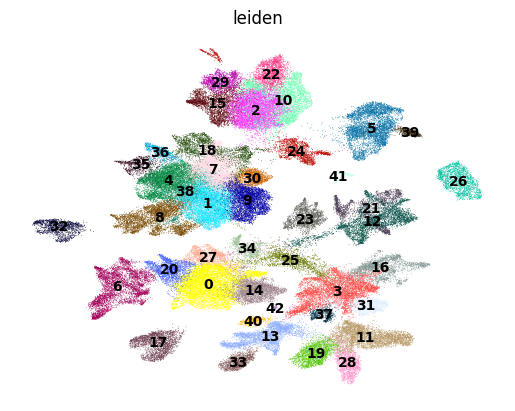

In [116]:
sc.pl.umap(adata, color = ['leiden'], frameon = False, legend_loc = "on data")

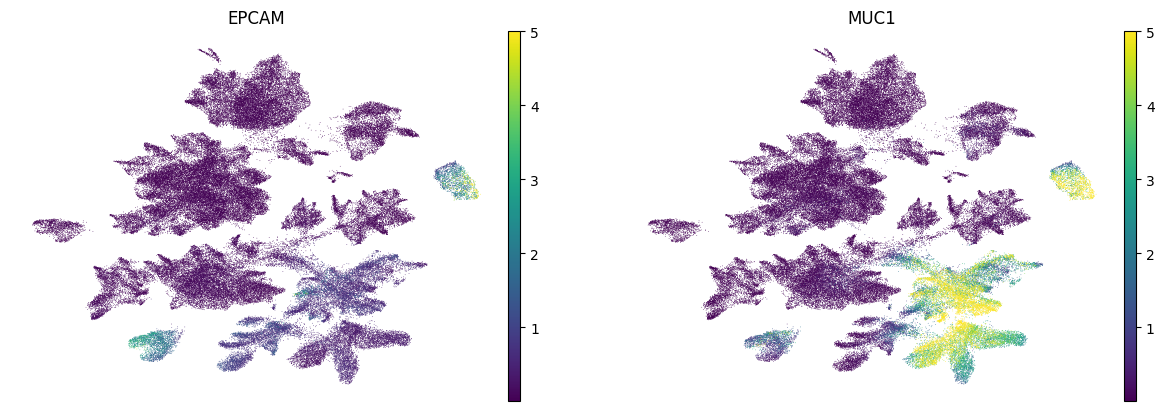

In [117]:
sc.pl.umap(adata, color = ['EPCAM', 'MUC1'], frameon = False, layer = 'scvi_normalized', vmax = 5)
#, layer = 'scvi_normalized'

In [118]:
cell_type = {"0":"Macrophage",
"1":"Fibroblast",
"2":"CD4+ T-cell",
"3":"AT2",
"4":"AT1",
"5":"CD8+ T-cell",
"6":"Endothelial cell",
"7":"Plasma cell",
"8":"Macrophage",
"9":"AT2",
"10":"Fibroblast",
"11":"Fibroblast",
"12":"Macrophage",
"13":"Macrophage",
"14":"Airway epithelial",
"15":"Airway epithelial",
"16":"Monocyte",
"17":"Airway epithelial",
"18":"B-cell",
"19":"Aerocyte",
"20":"Airway epithelial",
"21":"Smooth muscle cell",
"22":"Cycling T/NK",
"23":"Neuronal cell",
"24":"Denditic cell",
"25":"Pericyte",
"26":"Fibroblast",
"27":"Erythroid-like",
"28":"Macrophage"
}

In [119]:
adata.obs['cell type'] = adata.obs.leiden.map(cell_type)

/opt/homebrew/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/homebrew/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


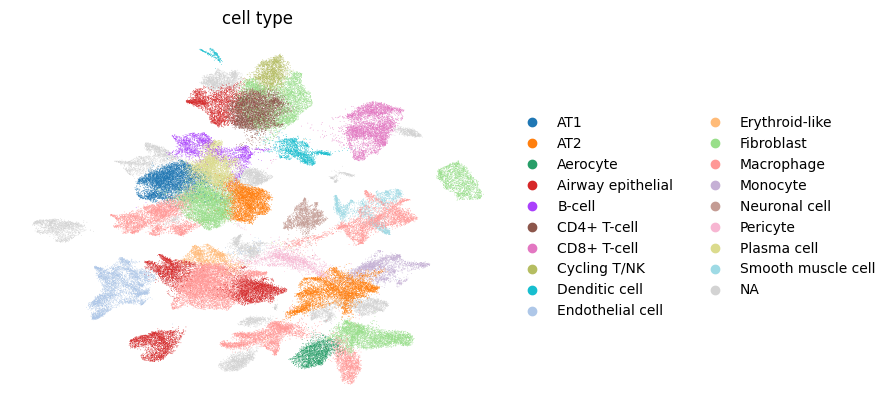

In [120]:
sc.pl.umap(adata, color = ['cell type'], frameon = False)

In [121]:
adata

AnnData object with n_obs × n_vars = 108822 × 21306
    obs: 'Sample', 'doublet', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', '_scvi_batch', '_scvi_labels', 'leiden', '_scvi_raw_norm_scaling', 'cell type'
    var: 'n_cells'
    uns: 'log1p', '_scvi_uuid', '_scvi_manager_uuid', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'Sample_colors', 'rank_genes_groups', 'cell type_colors'
    obsm: '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs', 'X_scVI', 'X_umap'
    layers: 'counts', 'scvi_normalized'
    obsp: 'distances', 'connectivities'

In [122]:
adata.uns['scvi_markers'] = markers_scvi
adata.uns['markers'] = markers

In [123]:
adata.write_h5ad('integrated.h5ad')

In [124]:
model.save('model.model')

## Analysis

In [125]:
import scanpy as sc
import scvi
import seaborn as sns
import numpy as np
import pandas as pd

### Counting Cells

In [127]:
adata = sc.read_h5ad('integrated.h5ad')

In [128]:
adata.obs.Sample.unique().tolist()

['cv19/GSE171524']

In [129]:
def map_condition(x):
    if 'cov' in x:
        return 'COVID19'
    else:
        return 'control'

In [130]:
adata.obs['condition'] = adata.obs.Sample.map(map_condition)
adata.obs

,Sample,doublet,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo,_scvi_batch,_scvi_labels,leiden,_scvi_raw_norm_scaling,cell type,condition
TCATATCTCTTCTAAC-1_5,cv19/GSE171524,False,1535,1535,4616.0,0.0,0.0,0.0,0.000000,0,0,28,2.171081,Macrophage,control
TGCAGTAAGGCCACCT-1_5,cv19/GSE171524,False,1476,1476,4428.0,0.0,0.0,3.0,0.067751,0,0,28,2.262955,Macrophage,control
CGGGACTAGTCACTCA-1_5,cv19/GSE171524,False,1607,1607,3857.0,0.0,0.0,1.0,0.025927,0,0,28,2.599428,Macrophage,control
ACCTGTCCAGGGTCTC-1_5,cv19/GSE171524,False,1592,1592,3913.0,0.0,0.0,0.0,0.000000,0,0,28,2.557545,Macrophage,control
CACAGGCTCGCATTGA-1_5,cv19/GSE171524,False,1603,1603,3685.0,0.0,0.0,3.0,0.081411,0,0,28,2.717391,Macrophage,control
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CCTAAGAAGTTGTCAC-1_27,cv19/GSE171524,False,344,344,413.0,0.0,0.0,0.0,0.000000,0,0,25,24.213076,Pericyte,control
CGTGAATCATGTCTAG-1_27,cv19/GSE171524,False,350,350,402.0,0.0,0.0,0.0,0.000000,0,0,9,24.937656,AT2,control
GCCGATGAGTAAACGT-1_27,cv19/GSE171524,False,326,326,401.0,0.0,0.0,8.0,1.995013,0,0,3,24.937656,AT2,control
AGGGTGAGTATCAGGG-1_27,cv19/GSE171524,False,331,331,402.0,0.0,0.0,0.0,0.000000,0,0,3,24.937656,AT2,control


In [131]:
num_tot_cells = adata.obs.groupby(['Sample']).count()
num_tot_cells = dict(zip(num_tot_cells.index, num_tot_cells.doublet))
num_tot_cells

/var/folders/9h/zlpjccbn02bfv55zvvdqbb2m0000gn/T/ipykernel_52392/2419454245.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  num_tot_cells = adata.obs.groupby(['Sample']).count()


{'cv19/GSE171524': 108822}

In [132]:
cell_type_counts = adata.obs.groupby(['Sample', 'condition', 'cell type']).count()
cell_type_counts = cell_type_counts[cell_type_counts.sum(axis = 1) > 0].reset_index()
cell_type_counts = cell_type_counts[cell_type_counts.columns[0:4]]
cell_type_counts

/var/folders/9h/zlpjccbn02bfv55zvvdqbb2m0000gn/T/ipykernel_52392/2058450824.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cell_type_counts = adata.obs.groupby(['Sample', 'condition', 'cell type']).count()


,Sample,condition,cell type,doublet
0,cv19/GSE171524,control,AT1,5103
1,cv19/GSE171524,control,AT2,9300
2,cv19/GSE171524,control,Aerocyte,2039
3,cv19/GSE171524,control,Airway epithelial,9686
4,cv19/GSE171524,control,B-cell,2165
5,cv19/GSE171524,control,CD4+ T-cell,5605
6,cv19/GSE171524,control,CD8+ T-cell,4674
7,cv19/GSE171524,control,Cycling T/NK,1902
8,cv19/GSE171524,control,Denditic cell,1871
9,cv19/GSE171524,control,Endothelial cell,4444


In [133]:
cell_type_counts['total_cells'] = cell_type_counts.Sample.map(num_tot_cells).astype(int)
cell_type_counts['frequency'] = cell_type_counts.doublet / cell_type_counts.total_cells
cell_type_counts

,Sample,condition,cell type,doublet,total_cells,frequency
0,cv19/GSE171524,control,AT1,5103,108822,0.046893
1,cv19/GSE171524,control,AT2,9300,108822,0.085461
2,cv19/GSE171524,control,Aerocyte,2039,108822,0.018737
3,cv19/GSE171524,control,Airway epithelial,9686,108822,0.089008
4,cv19/GSE171524,control,B-cell,2165,108822,0.019895
5,cv19/GSE171524,control,CD4+ T-cell,5605,108822,0.051506
6,cv19/GSE171524,control,CD8+ T-cell,4674,108822,0.042951
7,cv19/GSE171524,control,Cycling T/NK,1902,108822,0.017478
8,cv19/GSE171524,control,Denditic cell,1871,108822,0.017193
9,cv19/GSE171524,control,Endothelial cell,4444,108822,0.040837


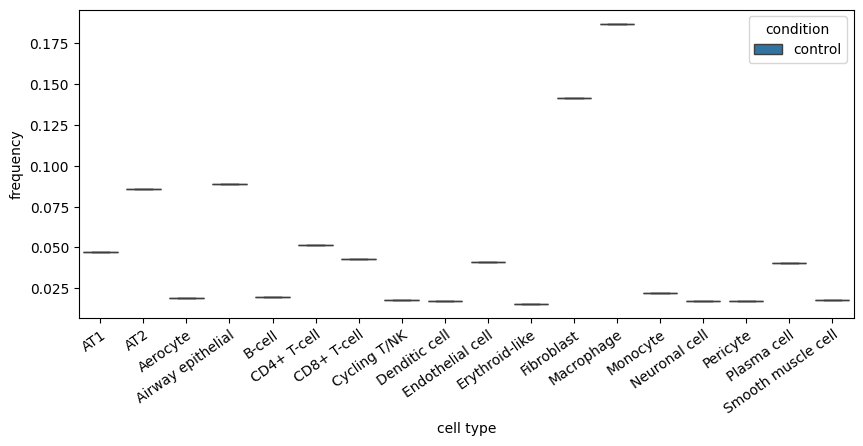

In [134]:
import matplotlib.pyplot as plt
plt.figure(figsize = (10,4))
ax = sns.boxplot(data = cell_type_counts, x = 'cell type', y = 'frequency', hue = 'condition')
plt.xticks(rotation = 35, rotation_mode = 'anchor', ha = 'right')
plt.show()

## Differential Expression

In [135]:
subset = adata[adata.obs['cell type'].isin(['AT1', 'AT2'])].copy()

In [139]:
pip install diffxpy

  Using cached toolz-0.12.1-py3-none-any.whl.metadata (5.1 kB)
  Using cached click-8.1.7-py3-none-any.whl.metadata (3.0 kB)
  Using cached zipp-3.18.1-py3-none-any.whl.metadata (3.5 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 1.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.7/140.7 kB 1.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 3.2 MB/s eta 0:00:00a 0:00:01
Using cached toolz-0.12.1-py3-none-any.whl (56 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 2.7 MB/s eta 0:00:00a 0:00:01
Using cached click-8.1.7-py3-none-any.whl (97 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.0/172.0 kB 2.7 MB/s eta 0:00:00 0:00:01
Using cached zipp-3.18.1-py3-none-any.whl (8.2 kB)
Note: you may need to restart the kernel to use updated packages.


In [140]:
import diffxpy.api as de

In [141]:
subset.X = subset.X.toarray()

In [142]:
len(subset.var)

21306

In [143]:
subset

AnnData object with n_obs × n_vars = 14403 × 21306
    obs: 'Sample', 'doublet', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', '_scvi_batch', '_scvi_labels', 'leiden', '_scvi_raw_norm_scaling', 'cell type', 'condition'
    var: 'n_cells'
    uns: 'Sample_colors', '_scvi_manager_uuid', '_scvi_uuid', 'cell type_colors', 'leiden', 'leiden_colors', 'log1p', 'markers', 'neighbors', 'rank_genes_groups', 'scvi_markers', 'umap'
    obsm: 'X_scVI', 'X_umap', '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs'
    layers: 'counts', 'scvi_normalized'
    obsp: 'connectivities', 'distances'

In [144]:
sc.pp.filter_genes(subset, min_cells=100)

In [145]:
len(subset.var)

13182

In [146]:
subset.obs = subset.obs.rename(columns = {'cell type':'cell_type'})

In [147]:
subset.obs

,Sample,doublet,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo,_scvi_batch,_scvi_labels,leiden,_scvi_raw_norm_scaling,cell_type,condition
GCACGTGAGGTCGTCC-1_5,cv19/GSE171524,False,504,504,647.0,0.0,0.0,0.0,0.000000,0,0,3,15.479876,AT2,control
GTCAGCGAGTCAACAA-1_5,cv19/GSE171524,False,467,467,535.0,0.0,0.0,0.0,0.000000,0,0,3,18.761726,AT2,control
GGGTGTCTCTACGCAA-1_11,cv19/GSE171524,False,2449,2449,5844.0,0.0,0.0,7.0,0.119781,0,0,3,1.712915,AT2,control
TTGGATGGTACAGAAT-1_11,cv19/GSE171524,False,2540,2540,5739.0,0.0,0.0,1.0,0.017425,0,0,4,1.745505,AT1,control
AACCAACCAGACTGCC-1_11,cv19/GSE171524,False,2427,2427,5547.0,0.0,0.0,3.0,0.054083,0,0,4,1.804403,AT1,control
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTGGATCATAGGCT-1_27,cv19/GSE171524,False,329,329,406.0,0.0,0.0,1.0,0.246305,0,0,3,24.691359,AT2,control
CGTGAATCATGTCTAG-1_27,cv19/GSE171524,False,350,350,402.0,0.0,0.0,0.0,0.000000,0,0,9,24.937656,AT2,control
GCCGATGAGTAAACGT-1_27,cv19/GSE171524,False,326,326,401.0,0.0,0.0,8.0,1.995013,0,0,3,24.937656,AT2,control
AGGGTGAGTATCAGGG-1_27,cv19/GSE171524,False,331,331,402.0,0.0,0.0,0.0,0.000000,0,0,3,24.937656,AT2,control


In [148]:
res = de.test.wald(data=subset,
             formula_loc= '~ 1 + cell_type',
             factor_loc_totest='cell_type'
                  )

training location model: False
training scale model: True
iter   0: ll=165057470.066759
iter   1: ll=165057470.066759, converged: 0.00% (loc: 100.00%, scale update: False), in 0.00sec
iter   2: ll=67259091.156949, converged: 0.00% (loc: 0.00%, scale update: True), in 77.74sec
iter   3: ll=67259091.156949, converged: 0.00% (loc: 100.00%, scale update: False), in 0.00sec
iter   4: ll=67014635.880804, converged: 99.61% (loc: 99.61%, scale update: True), in 68.67sec
iter   5: ll=67014635.880804, converged: 99.61% (loc: 100.00%, scale update: False), in 0.00sec
iter   6: ll=66948656.373888, converged: 99.95% (loc: 99.95%, scale update: True), in 28.08sec
iter   7: ll=66948656.373888, converged: 99.95% (loc: 100.00%, scale update: False), in 0.00sec
iter   8: ll=66940434.937935, converged: 99.98% (loc: 99.98%, scale update: True), in 20.04sec
iter   9: ll=66940434.937935, converged: 99.98% (loc: 100.00%, scale update: False), in 0.00sec
iter  10: ll=66915821.114777, converged: 99.99% (loc: 9

ZeroDivisionError: float division by zero

In [ ]:
dedf = res.summary().sort_values('log2fc', ascending = False).reset_index(drop = True)
dedf

In [ ]:
subset.obs.cell_type.unique()

In [ ]:
most_up = dedf.iloc[0].gene
i = np.where(subset.var_names == most_up)[0][0]

a = subset[subset.obs.cell_type == 'AT1'].X[:, i]
b = subset[subset.obs.cell_type == 'AT2'].X[:, i]
print(f"{most_up} expression:")
print(f"AT1: {a.mean()}")
print(f"AT2: {b.mean()}")

In [ ]:
dedf['log2fc'] = dedf['log2fc']*-1
dedf = dedf.sort_values('log2fc', ascending = False).reset_index(drop = True)
dedf

In [ ]:
dedf = dedf[(dedf.qval < 0.05) & (abs(dedf.log2fc) > .5)]
dedf

In [ ]:
dedf = dedf[dedf['mean'] > 0.15]
dedf

In [ ]:
genes_to_show = dedf[-25:].gene.tolist() + dedf[:25].gene.tolist() #top 25 and bottom 25 from sorted df

In [ ]:
sc.pl.heatmap(subset, genes_to_show, groupby='cell_type', swap_axes=True)

In [ ]:
model  = scvi.model.SCVI.load('model.model', adata)

In [ ]:
model

In [ ]:
scvi_de = model.differential_expression(
    idx1 = [adata.obs['cell type'] == 'AT1'],
    idx2 = [adata.obs['cell type'] == 'AT2']
    )


In [ ]:
scvi_de

In [ ]:
scvi_de = scvi_de[(scvi_de['is_de_fdr_0.05']) & (abs(scvi_de.lfc_mean) > .5)]
scvi_de = scvi_de.sort_values('lfc_mean')
scvi_de

In [ ]:
scvi_de = scvi_de[(scvi_de.raw_normalized_mean1 > .5) | (scvi_de.raw_normalized_mean2 > .5)]
scvi_de

In [ ]:
genes_to_show = scvi_de[-25:].index.tolist() + scvi_de[:25].index.tolist() #top 25 and bottom 25 from sorted df

In [ ]:
sc.pl.heatmap(subset, genes_to_show, groupby='cell_type', swap_axes=True, layer = 'scvi_normalized',
              log = True)

## GO Enrichment

In [ ]:
import gseapy as gp #this method requires internet connection

In [ ]:
gp.get_library_name()

In [ ]:
subset

In [ ]:
enr = gp.enrichr(gene_list= dedf[dedf.log2fc > 0].gene.tolist(),
                 gene_sets=['KEGG_2021_Human','GO_Biological_Process_2021'],
                 organism='human', # don't forget to set organism to the one you desired!
                 outdir=None, # don't write to disk,
                 background = subset.var_names.tolist()
                )

In [ ]:
enr.results

## Comparisons

In [ ]:
sc.pl.violin(subset[subset.obs.cell_type == 'AT2'], 'ETV5', groupby='condition')

In [ ]:
from scipy import stats

In [ ]:
temp = subset[subset.obs.cell_type == 'AT2']

i = np.where(temp.var_names == 'ETV5')[0][0]

In [ ]:
a = temp[temp.obs.condition == 'COVID19'].X[:,i]
b = temp[temp.obs.condition == 'control'].X[:,i]

In [ ]:
stats.mannwhitneyu(a, b)

## Score gene signature

In [ ]:
#gene signature, ie, input list of genes from user
with open('datp_sig.txt') as f:
    datp_sig = [x.strip() for x in list(f)]

In [ ]:
sc.tl.score_genes(subset, datp_sig, score_name = 'datp')

In [ ]:
subset.obs

In [ ]:
sc.pl.violin(subset, 'datp', groupby='condition')

In [ ]:
a = subset[subset.obs.condition == 'COVID19'].obs.datp.values
b = subset[subset.obs.condition == 'control'].obs.datp.values
stats.mannwhitneyu(a, b)

In [ ]:
sc.pl.umap(subset, color = 'datp', vmax = 1)

## For Thumbnail

In [ ]:
from matplotlib.pyplot import rc_context

In [ ]:
adata

In [ ]:
with rc_context({'figure.figsize': (8,8)}):
    sc.pl.umap(adata, color = ['cell type'], frameon = False, s = 5, legend_loc = 'on data',
              legend_fontsize=12, legend_fontoutline=2)

In [ ]:
with rc_context({'figure.figsize': (8,8)}):
    sc.pl.umap(adata, color = ['MUC1'], frameon = False, layer = 'scvi_normalized', vmax = 5, s = 5)